# Imports:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Reading the dataset:

In [ ]:
df = pd.read_csv("../input/bse-sensex/BSESN.csv")
df["Date"] = pd.to_datetime(df["Date"])
df.head()

# Visualization:

## Open price:

In [ ]:
fig = px.line(df, x='Date', y="Open", title="Openning price of the Stock:")
fig.update_xaxes(rangeslider_visible=True,
                    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])))
fig.show()

## Close price:

In [ ]:
fig = px.line(df, x='Date', y="Close", title="Closing price of the Stock:")
fig.update_xaxes(rangeslider_visible=True,
                    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])))
fig.show()

- Big dip on OCT 2008.

<p>
<a href="https://www.rediff.com/money/2008/oct/24bcrisis10.htm">
<img border="0" alt="W3Schools" src="https://i.ibb.co/pvLThcs/download.png" width="500" height="500">
</a>
</p>
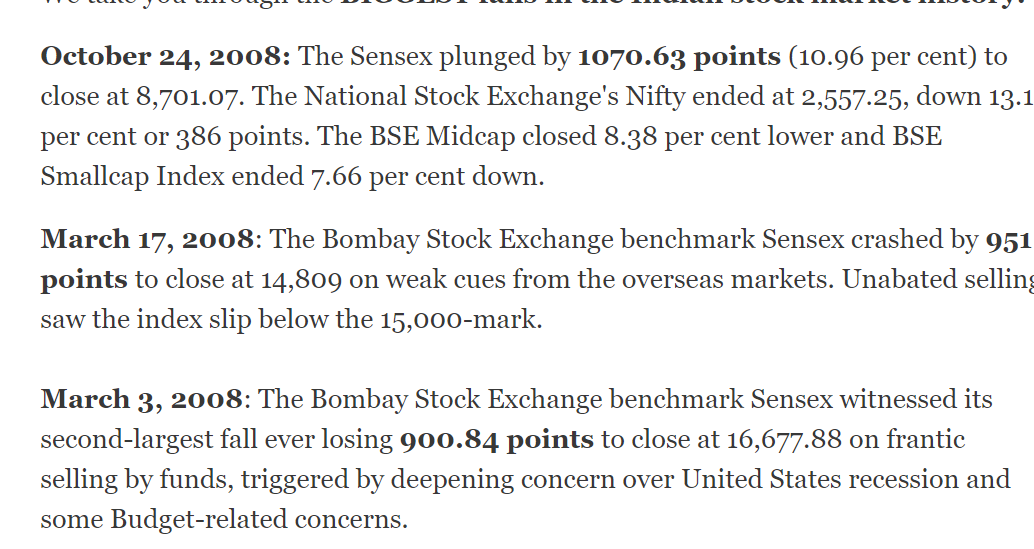

- Big dip on march 2020 due to corona virus

<p>
<a href="https://www.thehindubusinessline.com/markets/stock-markets/stock-market-updates-for-march-12-2020/article31046636.ece#">
<img border="0" alt="W3Schools" src="https://bl.thgim.com/incoming/wdnmf0/article31046621.ece/alternates/WIDE_960/Sensex-18jpg" width="500" height="500">
</a>
</p>

## CandleStick:

In [ ]:
fig = go.Figure(data=[go.Candlestick(x=df['Date'],
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'])])
fig.update_xaxes(rangeslider_visible=False)
fig.show()

# Sentiment analysis:

## Using the *India news headlines*

In [ ]:
sentdf = pd.read_csv("../input/indianewsheadlines/india-news-headlines.csv")

- Selecting all the headline that contains "Sensex" or "sensex".
- Changinf the date and time format

In [ ]:
sentdf = sentdf.loc[sentdf['headline_text'].apply(lambda x: 'Sensex' in x or 'sensex' in x)]
sentdf = sentdf.reset_index(drop = True)
sentdf['publish_date'] = pd.to_datetime(sentdf["publish_date"], format='%Y%m%d', dayfirst=True)

- Visualizing the most used words using wordcloud.

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
comment_words = ' '
stopwords = set(STOPWORDS)

for val in sentdf.headline_text: 
    val = str(val)
    tokens = val.split() 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
    for words in tokens: 
        comment_words = comment_words + words + ' '

wordcloud = WordCloud(width = 1800, height = 1800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words)

plt.figure(figsize = (18, 18), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 

- Using **NLTK VEDER** analyzer.
    - Adding diffrent values from the analyzer to the dataset(containg sensex).
    - give us scores of the following categories:
        - Positive
        - Negative
        - Neutral
        - Compound
            - The compound score is the sum of positive, negative & neutral scores which is then normalized between -1(most extreme negative) and +1 (most extreme positive).
            - The more Compound score closer to +1, the higher the positivity of the text.
    
- Advantages
    - It does not require any training data.
    - It can very well understand the sentiment of a text containing emoticons, slangs, conjunctions, capital words, punctuations and much more.
    - It works excellent on social media text.
    - VADER can work with multiple domains.

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
sentdf['compound'] = [analyzer.polarity_scores(x)['compound'] for x in sentdf['headline_text']]
sentdf['neg'] = [analyzer.polarity_scores(x)['neg'] for x in sentdf['headline_text']]
sentdf['neu'] = [analyzer.polarity_scores(x)['neu'] for x in sentdf['headline_text']]
sentdf['pos'] = [analyzer.polarity_scores(x)['pos'] for x in sentdf['headline_text']]


- Applying a lambda function which will subtract the open price and the closing price of stock on the day
- If the sbtraction is less then 0 i.e. the Close price is greater then the open price *(profit)* then it will change it to 0.5 and if the subtraction is more than 0 i.e. the close price is smaller than the open price *(loss)* it will change it to -0.5

In [ ]:
df['good'] = df['Open'] - df['Close'] < 0
df['good'] = df['good'].apply(lambda x: 0.5 if x == True else -0.5)

- Plotting sentiment and actual price on the graph.
- for actual table http://bse-2001-2010.blogspot.com/p/bse-sensex-historical-prices-in-year_7944.html

In [ ]:
fig = px.scatter(df, y=df.good,x=df['Date'])
# fig.add_line(sentdf, y=,x=)
fig.add_trace(
    go.Scatter(
        x=sentdf['publish_date'],
        y=sentdf.compound
    ))
fig.show()

# Pre-Processing:

In [ ]:
import math
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

-  Keeping only *CLOSE* column, for prediction.

In [ ]:
data = df.filter(['Close']).values
data = data[~np.isnan(data)]
data = np.reshape(data, (-1, 1)) 
training_len = math.ceil(len(data)*0.8)
training_len

- Scalling the Data

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

- Setting window size to be 60

In [ ]:
train_data = scaled_data[0:training_len, :]

# Splitting into X_train and y_train
X_train = []
y_train = []

for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)
    

In [ ]:
X_train.shape

- LSTM expectes 3-D array, so we have to reshape the data

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0],
                               X_train.shape[1], 1))
X_train.shape

# MODEL:

In [ ]:
# model = Sequential()
# model.add(LSTM(50, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2]),activation = 'relu'))
# model.add(LSTM(50, return_sequences = True))
# model.add(LSTM(50, return_sequences = False))
# model.add(Dense(50))
# model.add(Dense(25))
# model.add(Dense(1))

# model.compile(optimizer='adam', loss='mean_squared_error')
# model.summary()

In [ ]:
# model.fit(X_train, y_train, batch_size=64, epochs = 25)

In [ ]:
#model.save("model")

In [ ]:
import keras
model = keras.models.load_model('../input/trainedmodel/model')

# Preprocessing the test data

In [ ]:
test_data = scaled_data[training_len-60:, :]

X_test = []
y_test = data[training_len:, :]

for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])

X_test = np.array(X_test)
X_test.shape

In [ ]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

In [ ]:
prediction = model.predict(X_test)
prediction = scaler.inverse_transform(prediction)

# Visualizing prediction vs actual

In [ ]:
plt.figure(figsize=(16, 8))
plt.title("MODEL")
plt.xlabel("Date")
plt.ylabel("Close price")
plt.plot(y_test)
plt.plot(prediction)
plt.legend(['Actual', 'Prediction'], loc='lower right')